# Data Generation

The below code generates the required data and saves as an CSV file, it first generates the random values [m1, m2, x1, y1, x2, y2, vx1, vy1, vx2, vy2, t] and uses the solve_ivp module from scipy library to give the corresponding output [x1(t), y1(t), x2(t), y2(t)]

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# seed
np.random.seed(42)

# Number of samples
N = 3000

# Parameter ranges
mass_range = (1, 50)      # (exclusive, inclusive]
pos_vel_range = (-100, 100) # for x, y, vx, vy
t_range = (1, 200)        # [1, 200]
G = 1  # Gravitational constant

# Differential Equation setup
def ode(t, y, m1, m2):
   x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
   dx = x2 - x1
   dy = y2 - y1
   dist3 = (dx**2 + dy**2)**1.5 + 1e-8  # add epsilon to avoid zero division
   ax1 = G * m2 * dx / dist3
   ay1 = G * m2 * dy / dist3
   ax2 = -G * m1 * dx / dist3
   ay2 = -G * m1 * dy / dist3
   return [vx1, vy1, vx2, vy2, ax1, ay1, ax2, ay2]

data = []
for _ in range(N):
   m1 = np.random.uniform(*mass_range)
   m2 = np.random.uniform(*mass_range)
   x1, y1 = np.random.uniform(*pos_vel_range, 2)
   x2, y2 = np.random.uniform(*pos_vel_range, 2)
   vx1, vy1 = np.random.uniform(*pos_vel_range, 2)
   vx2, vy2 = np.random.uniform(*pos_vel_range, 2)
   t = np.random.uniform(*t_range)

   y0 = [x1, y1, x2, y2, vx1, vy1, vx2, vy2]
   sol = solve_ivp(
      ode,
      [0, t],
      y0,
      args=(m1, m2),
      t_eval=[t],
      rtol=1e-8,
      atol=1e-8
   )
   if not sol.success:
      continue
   xf = sol.y[:, -1]
   # Input: [m1, m2, x1, y1, x2, y2, vx1, vy1, vx2, vy2, t]
   # Output: [x1(t), y1(t), x2(t), y2(t)]
   row = [
      m1, m2, x1, y1, x2, y2, vx1, vy1, vx2, vy2, t,
      xf[0], xf[1], xf[2], xf[3]
   ]
   data.append(row)

columns = [
   'm1', 'm2', 'x1', 'y1', 'x2', 'y2', 'vx1', 'vy1', 'vx2', 'vy2', 't',
   'x1_t', 'y1_t', 'x2_t', 'y2_t'
]
df = pd.DataFrame(data, columns=columns)
df.to_csv('two_body_data.csv', index=False)
print("Saved generated data to CSV")

Saved generated data to CSV


# Spliting and Normalizing the data

This cell loads the previously generated data and splits it into 80:20 for training:testing. Further the training data is min_max normalized for smooth training.

In [2]:
# Load data
df = pd.read_csv('two_body_data.csv')

# Split inputs and outputs
X = df.loc[:, ['m1', 'm2', 'x1', 'y1', 'x2', 'y2', 'vx1', 'vy1', 'vx2', 'vy2', 't']].values
Y = df.loc[:, ['x1_t', 'y1_t', 'x2_t', 'y2_t']].values

# Split into train (80%) and test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(
   X, Y, test_size=0.2, random_state=42  # consistent split
)

# Normalize inputs and outputs (fit only on train)
input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

X_train_scaled = input_scaler.fit_transform(X_train)
X_test_scaled = input_scaler.transform(X_test)

Y_train_scaled = output_scaler.fit_transform(Y_train)
Y_test_scaled = output_scaler.transform(Y_test)

#print(X_train_scaled[:5])  # quick look at normalized inputs

# Model Architecture

*   Input layer: 11 inputs
*   1st Fully connected layer: 128 neurons, activation function: tanh
*   2nd Fully connected layer: 128 neurons, activation function: tanh
*   3rd Fully connected layer: 128 neurons, activation function: tanh
*   Output layer: 4 outputs



In [3]:
# Define the model
model = Sequential([
   Dense(128, activation='tanh', input_shape=(11,)),
   Dense(128, activation='tanh'),
   Dense(128, activation='tanh'),
   Dense(4)  # Output: [x1_t, y1_t, x2_t, y2_t]
])

model.compile(optimizer='adam', loss='mse')

# Trying a basic MLP, might need to tune layer sizes

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Model Training
This cell trains our neural network to predict the final positions of two gravitational bodies. We use a custom callback to monitor the training progress by calculating the percentage Mean Squared Error (MSE) at each epoch.

The percentage MSE is calculated by dividing the raw MSE by the variance of the training outputs and multiplying by 100. This gives us a normalized measure of error that's easier to interpret - it tells us what percentage of the output variance our model fails to explain.

Lower percentage MSE values indicate better model performance, with 0% representing a perfect prediction. The training runs for 100 epochs with a batch size of 32.

In [4]:
# Compute output variance for percentage MSE (on scaled outputs)
output_var = np.var(Y_train_scaled)

# Custom callback to print percentage MSE and residual ODE loss each epoch
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_train, input_scaler, output_scaler, output_var, num_samples=50):
        super().__init__()
        self.X_train = X_train
        self.input_scaler = input_scaler
        self.output_scaler = output_scaler
        self.output_var = output_var
        self.G = 1.0  # Gravitational constant
        self.num_samples = min(num_samples, len(X_train))

    def on_epoch_end(self, epoch, logs=None):
        # Calculate percentage MSE
        mse = logs['loss']
        percent_mse = (mse / self.output_var) * 100 if self.output_var > 0 else 0.0

        # Calculate residual ODE loss without affecting training
        residual_loss = self.calculate_ode_residual()

        print(f"Epoch {epoch+1}: Percentage MSE = {percent_mse:.2f}%, Residual ODE Loss = {residual_loss:.6f}")

    def calculate_ode_residual(self):
        # Sample data for residual calculation
        batch_indices = np.random.choice(len(self.X_train), self.num_samples, replace=False)
        X_batch = self.X_train[batch_indices]

        # Extract parameters
        m1 = X_batch[:, 0]
        m2 = X_batch[:, 1]
        t = X_batch[:, 10]

        # Create a small time delta for approximating derivatives
        delta_t = 0.01 * t  # Scale delta_t proportional to t

        # Create inputs for t, t+delta_t, and t-delta_t
        X_current = X_batch.copy()

        X_plus = X_batch.copy()
        X_plus[:, 10] = t + delta_t

        X_minus = X_batch.copy()
        X_minus[:, 10] = np.maximum(t - delta_t, 0.1)  # Ensure time is positive

        # Combine all inputs for a single prediction
        X_all = np.vstack([X_current, X_plus, X_minus])
        X_all_scaled = self.input_scaler.transform(X_all)

        # Predict all positions at once
        positions_all_scaled = self.model.predict(X_all_scaled, verbose=0)
        positions_all = self.output_scaler.inverse_transform(positions_all_scaled)

        # Split the results
        positions = positions_all[:self.num_samples]
        positions_plus = positions_all[self.num_samples:2*self.num_samples]
        positions_minus = positions_all[2*self.num_samples:]

        # Extract predicted final positions
        x1_t = positions[:, 0]
        y1_t = positions[:, 1]
        x2_t = positions[:, 2]
        y2_t = positions[:, 3]

        # Extract positions at t+delta_t
        x1_plus = positions_plus[:, 0]
        y1_plus = positions_plus[:, 1]
        x2_plus = positions_plus[:, 2]
        y2_plus = positions_plus[:, 3]

        # Extract positions at t-delta_t
        x1_minus = positions_minus[:, 0]
        y1_minus = positions_minus[:, 1]
        x2_minus = positions_minus[:, 2]
        y2_minus = positions_minus[:, 3]

        # Calculate second derivatives using central difference
        d2x1_dt2 = (x1_plus - 2*x1_t + x1_minus) / (delta_t**2)
        d2y1_dt2 = (y1_plus - 2*y1_t + y1_minus) / (delta_t**2)
        d2x2_dt2 = (x2_plus - 2*x2_t + x2_minus) / (delta_t**2)
        d2y2_dt2 = (y2_plus - 2*y2_t + y2_minus) / (delta_t**2)

        # Calculate expected accelerations from gravitational law
        dx = x2_t - x1_t
        dy = y2_t - y1_t
        dist3 = np.power(dx*dx + dy*dy, 1.5) + 1e-8

        ax1_expected = self.G * m2 * dx / dist3
        ay1_expected = self.G * m2 * dy / dist3
        ax2_expected = -self.G * m1 * dx / dist3
        ay2_expected = -self.G * m1 * dy / dist3

        # Calculate residuals
        residual_x1 = np.mean((d2x1_dt2 - ax1_expected)**2)
        residual_y1 = np.mean((d2y1_dt2 - ay1_expected)**2)
        residual_x2 = np.mean((d2x2_dt2 - ax2_expected)**2)
        residual_y2 = np.mean((d2y2_dt2 - ay2_expected)**2)

        total_residual = residual_x1 + residual_y1 + residual_x2 + residual_y2
        return total_residual

# Train the model
history = model.fit(
    X_train_scaled, Y_train_scaled,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[CustomCallback(X_train, input_scaler, output_scaler, output_var, num_samples=50)]
)


Epoch 1: Percentage MSE = 107.15%, Residual ODE Loss = 0.814856
Epoch 2: Percentage MSE = 26.41%, Residual ODE Loss = 22.889768
Epoch 3: Percentage MSE = 25.00%, Residual ODE Loss = 7.594079
Epoch 4: Percentage MSE = 23.71%, Residual ODE Loss = 22.495751
Epoch 5: Percentage MSE = 22.77%, Residual ODE Loss = 1.457092
Epoch 6: Percentage MSE = 19.97%, Residual ODE Loss = 19.898171
Epoch 7: Percentage MSE = 16.80%, Residual ODE Loss = 1.493709
Epoch 8: Percentage MSE = 12.43%, Residual ODE Loss = 61.448144
Epoch 9: Percentage MSE = 9.61%, Residual ODE Loss = 1.169722
Epoch 10: Percentage MSE = 7.37%, Residual ODE Loss = 497.664536
Epoch 11: Percentage MSE = 6.21%, Residual ODE Loss = 4.872974
Epoch 12: Percentage MSE = 5.70%, Residual ODE Loss = 300.516449
Epoch 13: Percentage MSE = 5.22%, Residual ODE Loss = 23.731848
Epoch 14: Percentage MSE = 4.68%, Residual ODE Loss = 2.601489
Epoch 15: Percentage MSE = 4.25%, Residual ODE Loss = 1.765844
Epoch 16: Percentage MSE = 3.69%, Residual ODE

# Validation

In [5]:
# Predict on test set (scaled)
Y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform predictions and ground truth to original scale
Y_pred = output_scaler.inverse_transform(Y_pred_scaled)
Y_true = output_scaler.inverse_transform(Y_test_scaled)

# MAE
mae = tf.keras.losses.MeanAbsoluteError()(Y_true, Y_pred).numpy()

# Compute mean absolute value of true outputs for percentage calculation
mean_true = np.mean(np.abs(Y_true))

# Calculate percentage MAE
percentage_mae = (mae / mean_true) * 100 if mean_true != 0 else 0.0

print(f"Percentage MAE on test set: {percentage_mae:.2f}%")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Percentage MAE on test set: 6.50%


# Predicted and Actual trajectory plotter


---



This cell selects any random value from the test data and plots the actual and predicted trajectories for both the bodies




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


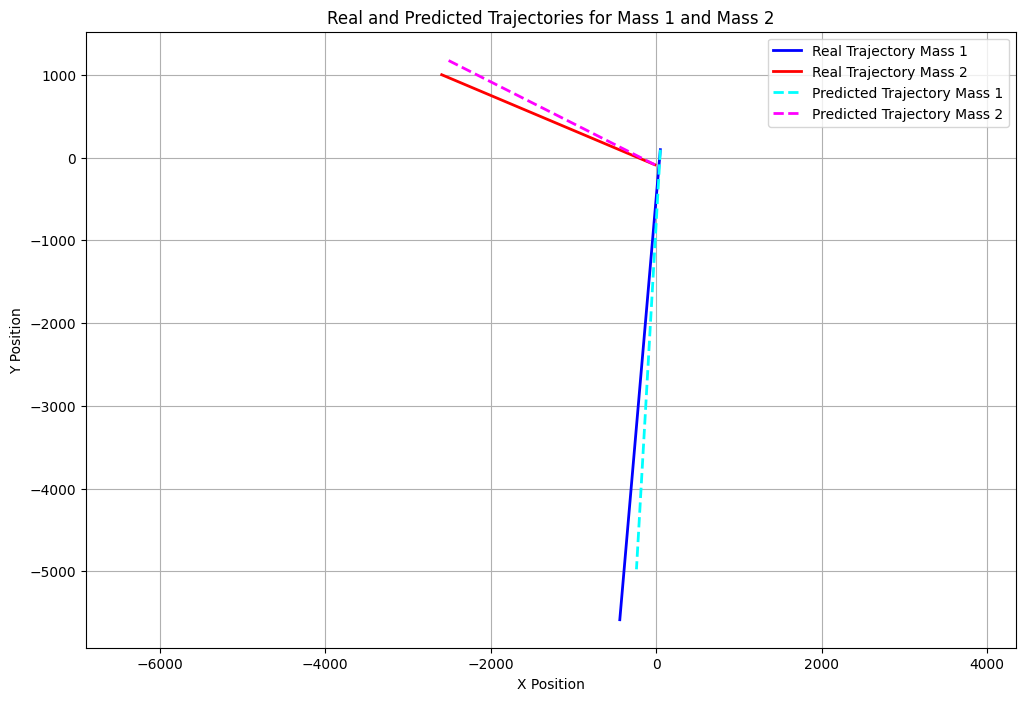

In [6]:
# Select a random index from test data
index = np.random.randint(0, len(X_test_scaled))

# Get the input features and true output for the selected point
x_input_scaled = X_test_scaled[index:index+1]
y_true_scaled = Y_test_scaled[index:index+1]

# Predict using the model
y_pred_scaled = model.predict(x_input_scaled)

# Inverse transform to original scale
x_input = input_scaler.inverse_transform(x_input_scaled)
y_true = output_scaler.inverse_transform(y_true_scaled)
y_pred = output_scaler.inverse_transform(y_pred_scaled)

# Extract initial conditions and time from input
m1, m2, x1, y1, x2, y2, vx1, vy1, vx2, vy2, t = x_input[0]

# Define the ODE system for simulation
def two_body_ode(t, y, m1, m2):
   x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
   dx = x2 - x1
   dy = y2 - y1
   dist3 = (dx**2 + dy**2)**1.5 + 1e-8
   ax1 = G * m2 * dx / dist3
   ay1 = G * m2 * dy / dist3
   ax2 = -G * m1 * dx / dist3
   ay2 = -G * m1 * dy / dist3
   return [vx1, vy1, vx2, vy2, ax1, ay1, ax2, ay2]

# Time points for trajectory
num_points = 100
t_span = (0, t)
t_eval = np.linspace(0, t, num_points)

# Initial state
y0 = [x1, y1, x2, y2, vx1, vy1, vx2, vy2]

# Solve ODE for ground truth trajectory
G = 1
sol = solve_ivp(two_body_ode, t_span, y0, args=(m1, m2), t_eval=t_eval, rtol=1e-8, atol=1e-8)

# Generate predicted trajectory by linear interpolation
pred_traj_p1_x = np.linspace(x1, y_pred[0, 0], num_points)
pred_traj_p1_y = np.linspace(y1, y_pred[0, 1], num_points)
pred_traj_p2_x = np.linspace(x2, y_pred[0, 2], num_points)
pred_traj_p2_y = np.linspace(y2, y_pred[0, 3], num_points)

# Plotting - CORRECTED to show all 4 trajectories properly
plt.figure(figsize=(12, 8))

# Plot ground truth trajectories
plt.plot(sol.y[0], sol.y[1], label='Real Trajectory Mass 1', color='blue', linewidth=2)
plt.plot(sol.y[2], sol.y[3], label='Real Trajectory Mass 2', color='red', linewidth=2)

# Plot predicted trajectories (linear interpolation)
plt.plot(pred_traj_p1_x, pred_traj_p1_y, label='Predicted Trajectory Mass 1',
       color='cyan', linestyle='--', linewidth=2)
plt.plot(pred_traj_p2_x, pred_traj_p2_y, label='Predicted Trajectory Mass 2',
       color='magenta', linestyle='--', linewidth=2)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Real and Predicted Trajectories for Mass 1 and Mass 2')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# Input cell


---



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

planet_logo = """
              .::.
             .:'  :.
      ,MMM8&&&.:'   .:'
      MMMMM88&&&&  .:'
     MMMMM88&&&&&&:'
     MMMMM88&&&&&&
   .:MMMMM88&&&&&&
  .:'  MMMMM88&&&&
.:'   .:'MMM8&&&'
:'  .:'
'::'

    DANCE OF THE PLANETS
"""
print(planet_logo)
print("\n TRAJECTORY PREDICTOR \n")


# Create input form
print("Enter parameters within these ranges:")
print("   Masses: (1, 50]")
print("   Positions/Velocities: [-100, 100]")
print("   Time: [1, 200]\n")

# Get user inputs with validation
def get_valid_input(prompt, min_val, max_val):
   while True:
      try:
         value = float(input(prompt))
         if min_val <= value <= max_val:
            return value
         else:
            print(f"Value must be between {min_val} and {max_val}. Try again.")
      except ValueError:
         print("Please enter a valid number.")

m1 = get_valid_input("Mass 1: ", 1.0, 50.0)
m2 = get_valid_input("Mass 2: ", 1.0, 50.0)
x1 = get_valid_input("X position of Mass 1: ", -100.0, 100.0)
y1 = get_valid_input("Y position of Mass 1: ", -100.0, 100.0)
x2 = get_valid_input("X position of Mass 2: ", -100.0, 100.0)
y2 = get_valid_input("Y position of Mass 2: ", -100.0, 100.0)
vx1 = get_valid_input("X velocity of Mass 1: ", -100.0, 100.0)
vy1 = get_valid_input("Y velocity of Mass 1: ", -100.0, 100.0)
vx2 = get_valid_input("X velocity of Mass 2: ", -100.0, 100.0)
vy2 = get_valid_input("Y velocity of Mass 2: ", -100.0, 100.0)
t = get_valid_input("Time to predict: ", 1.0, 200.0)

# Prediction
input_data = np.array([[m1, m2, x1, y1, x2, y2, vx1, vy1, vx2, vy2, t]])

input_scaled = input_scaler.transform(input_data)

prediction_scaled = model.predict(input_scaled)
prediction = output_scaler.inverse_transform(prediction_scaled)

# Display prediction results
print("\n PREDICTION RESULTS ")
print(f"At time t = {t:.2f}:")
print(f"Mass 1 position: ({prediction[0, 0]:.4f}, {prediction[0, 1]:.4f})")
print(f"Mass 2 position: ({prediction[0, 2]:.4f}, {prediction[0, 3]:.4f})")

# Input to plot trajectory or not:
plot_trajectory = input("\nDo you want to plot the trajectory? (yes/no): ").lower().strip()

if plot_trajectory in ['yes', 'y']:
   # Defination for the ODE system for simulation
   def two_body_ode(t, y, m1, m2):
      x1, y1, x2, y2, vx1, vy1, vx2, vy2 = y
      dx = x2 - x1
      dy = y2 - y1
      dist3 = (dx**2 + dy**2)**1.5 + 1e-8
      G = 1.0
      ax1 = G * m2 * dx / dist3
      ay1 = G * m2 * dy / dist3
      ax2 = -G * m1 * dx / dist3
      ay2 = -G * m1 * dy / dist3
      return [vx1, vy1, vx2, vy2, ax1, ay1, ax2, ay2]

   from scipy.integrate import solve_ivp

   # Time points for trajectory
   num_points = 100
   t_span = (0, t)
   t_eval = np.linspace(0, t, num_points)

   # Initial state
   y0 = [x1, y1, x2, y2, vx1, vy1, vx2, vy2]

   # Solve ODE for ground truth trajectory
   sol = solve_ivp(two_body_ode, t_span, y0, args=(m1, m2), t_eval=t_eval, rtol=1e-8, atol=1e-8)

   # Generate predicted trajectory (linear interpolation)
   pred_traj_p1_x = np.linspace(x1, prediction[0, 0], num_points)
   pred_traj_p1_y = np.linspace(y1, prediction[0, 1], num_points)
   pred_traj_p2_x = np.linspace(x2, prediction[0, 2], num_points)
   pred_traj_p2_y = np.linspace(y2, prediction[0, 3], num_points)

   # Plotting
   plt.figure(figsize=(12, 8))

   # Plot ground truth trajectories
   plt.plot(sol.y[0], sol.y[1], label='Real Trajectory Mass 1', color='blue', linewidth=2)
   plt.plot(sol.y[2], sol.y[3], label='Real Trajectory Mass 2', color='red', linewidth=2)

   # Plot predicted trajectories
   plt.plot(pred_traj_p1_x, pred_traj_p1_y, label='Predicted Trajectory Mass 1',
          color='cyan', linestyle='--', linewidth=2)
   plt.plot(pred_traj_p2_x, pred_traj_p2_y, label='Predicted Trajectory Mass 2',
          color='magenta', linestyle='--', linewidth=2)

   # Plot initial positions
   plt.scatter(x1, y1, label='Initial Mass 1', color='darkblue', marker='^', s=100)
   plt.scatter(x2, y2, label='Initial Mass 2', color='darkred', marker='^', s=100)

   # Plot final positions
   plt.scatter(prediction[0, 0], prediction[0, 1], label='Predicted Final Mass 1',
            color='cyan', marker='x', s=100)
   plt.scatter(prediction[0, 2], prediction[0, 3], label='Predicted Final Mass 2',
            color='magenta', marker='x', s=100)
   plt.scatter(sol.y[0, -1], sol.y[1, -1], label='Real Final Mass 1',
            color='blue', marker='o', s=100)
   plt.scatter(sol.y[2, -1], sol.y[3, -1], label='Real Final Mass 2',
            color='red', marker='o', s=100)

   # Error Calculation
   error1 = np.sqrt((prediction[0, 0] - sol.y[0, -1])**2 + (prediction[0, 1] - sol.y[1, -1])**2)
   error2 = np.sqrt((prediction[0, 2] - sol.y[2, -1])**2 + (prediction[0, 3] - sol.y[3, -1])**2)

   plt.annotate(f'Error Mass 1: {error1:.4f}', xy=(0.05, 0.95), xycoords='axes fraction')
   plt.annotate(f'Error Mass 2: {error2:.4f}', xy=(0.05, 0.90), xycoords='axes fraction')
   plt.annotate(f'Time: {t:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')
   plt.annotate(f'm1: {m1:.2f}, m2: {m2:.2f}', xy=(0.05, 0.80), xycoords='axes fraction')

   plt.xlabel('X Position')
   plt.ylabel('Y Position')
   plt.title('Dance of the Planets: Real and Predicted Trajectories')
   plt.legend()
   plt.grid(True)
   plt.axis('equal')
   plt.show()

   print("\n The cosmic dance is complete! ")
else:
   print("\nTrajectory plot skipped. Prediction complete!")



              .::.
             .:'  :.
      ,MMM8&&&.:'   .:'
      MMMMM88&&&&  .:'
     MMMMM88&&&&&&:'
     MMMMM88&&&&&&
   .:MMMMM88&&&&&&
  .:'  MMMMM88&&&&
.:'   .:'MMM8&&&'
:'  .:'
'::'

    DANCE OF THE PLANETS


 TRAJECTORY PREDICTOR 

Enter parameters within these ranges:
   Masses: (1, 50]
   Positions/Velocities: [-100, 100]
   Time: [1, 200]



KeyboardInterrupt: Interrupted by user